Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Download the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! chmod 600 /content/gdrive/MyDrive/kaggle/kaggle.json
! KAGGLE_CONFIG_DIR=/content/gdrive/MyDrive/kaggle kaggle datasets download -d amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset

covid19-pneumonia-normal-chest-xray-pa-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
local_zip = '/content/covid19-pneumonia-normal-chest-xray-pa-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
import pathlib
data_dir = pathlib.Path('/content/dataset')

Load using keras.preprocessing

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6902 files belonging to 3 classes.
Using 5522 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6902 files belonging to 3 classes.
Using 1380 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['covid', 'normal', 'pneumonia']


Visualize the data

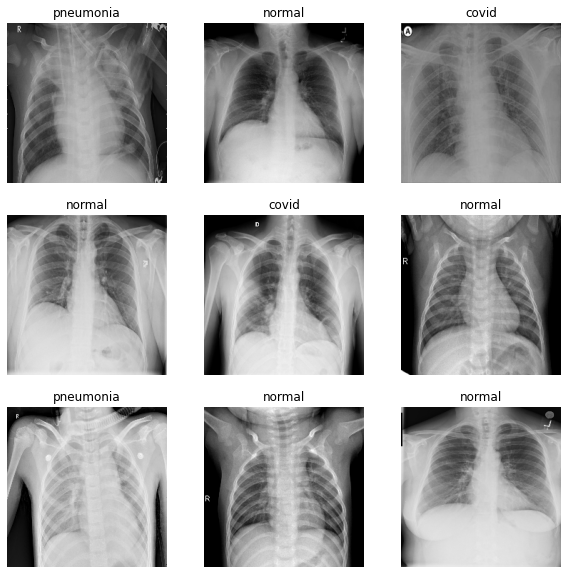

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

Standardize the data

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9995099


Create and Compile the model

In [ ]:
num_classes = 3

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
  layers.MaxPooling2D(2, 2),

  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),

  layers.Conv2D(256, (3,3), activation='relu'),
  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(4,4),
  layers.MaxPooling2D(2,2),

  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.1),

  layers.Dense(256, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 256)      

In [ ]:
# callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

Train the model

In [ ]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, lr_reduce]
)



Epoch 1/15
173/173 [==============================] - 56s 133ms/step - loss: 0.7699 - accuracy: 0.6539 - val_loss: 0.4786 - val_accuracy: 0.8297
Epoch 2/15
173/173 [==============================] - 12s 69ms/step - loss: 0.4971 - accuracy: 0.8012 - val_loss: 0.3951 - val_accuracy: 0.8558
Epoch 3/15
173/173 [==============================] - 12s 70ms/step - loss: 0.4116 - accuracy: 0.8368 - val_loss: 0.3348 - val_accuracy: 0.8819

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/15
173/173 [==============================] - 12s 69ms/step - loss: 0.3217 - accuracy: 0.8852 - val_loss: 0.2593 - val_accuracy: 0.9080
Epoch 5/15
173/173 [==============================] - 12s 70ms/step - loss: 0.2956 - accuracy: 0.8941 - val_loss: 0.2719 - val_accuracy: 0.8971

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/15
173/173 [==============================] - 12s 71ms/step - loss: 0.2544 - accuracy: 0.9114 - val_loss: 0.2

In [ ]:
model.evaluate(train_ds)

173/173 [==============================] - 4s 22ms/step - loss: 0.2162 - accuracy: 0.9267


[0.21622903645038605, 0.9266570210456848]

Visualize training results

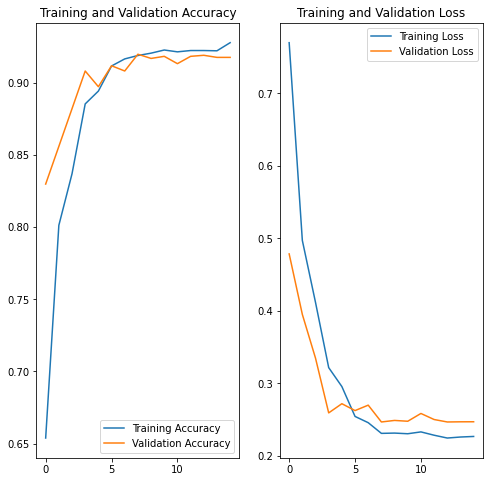

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Convert to TensorFlow Lite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpmzzjd765/assets


Predict on new data

Saving 00000963_007.png to 00000963_007.png
This image most likely belongs to normal with a 90.27 percent confidence.


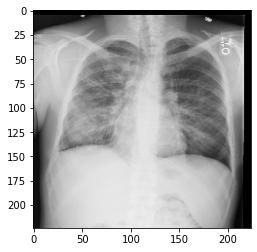

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  predictions = model.predict(images, batch_size=32)
  max_index = np.argmax(predictions[-1])
  score = tf.nn.softmax(predictions[0])

  print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)